# General context

Explanation of what to be done

# Inclusion and global variables

In [1]:
import os
import math
from dataclasses import dataclass, field
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import (
    DataLoader,
    Dataset
)

from sklearn.model_selection import train_test_split
import polars as pl

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    AutoModel,
    DataCollatorWithPadding,
)
import datasets
from peft import LoraConfig # type: ignore

from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import (
    BaseEstimator,
    ClassifierMixin,
)
# import keras_nlp
# import keras
# import keras.backend as K

## Set and define global configuration

In [2]:
DATABRICKS_STR  = "DATABRICKS"
KAGGLE_STR      = "KAGGLE"
LOCAL_STR       = "LOCAL"
MATPLOTBLUE     = "#1f77b4"
SEED            = 1010
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
DEBERTA_V3_CKPT = "microsoft/deberta-v3-base"
NUM_LABELS      = 5

@dataclass(frozen=True)
class ConfigurationSetting:
    name: str
    model_ckpt: str
    num_labels: int
    n_worker: int
    plot_color: str
    seed: int
    data_path: Path|None
    device: str
    torch_device:torch.device = field(init=False)
    
    def __post_init__(self):
        object.__setattr__(self, "torch_device", torch.device(self.device))

def configuration_builder(
    model_ckpt = "google-bert/bert-base-uncased",
    plot_color="#FFFFFF",
    seed=1010,
    device=None
) -> ConfigurationSetting:
    if os.getenv("DATABRICKS_RUNTIME_VERSION"):
        environment_name = DATABRICKS_STR
        n_worker=8
        data_path = None
    elif os.getenv("KAGGLE_KERNEL_RUN_TYPE"):
        environment_name = KAGGLE_STR
        n_worker = 2
        data_path = None
    else:
        environment_name = LOCAL_STR
        n_worker = math.floor(os.cpu_count() * 3/8) # type: ignore
        data_path = Path("../data")
    return ConfigurationSetting(
        name=environment_name,
        model_ckpt=model_ckpt,
        num_labels=5,
        n_worker=n_worker,
        plot_color=plot_color,
        seed=seed,
        data_path=data_path,
        device="cpu" if device is None else device
    )

configuration_item = configuration_builder(
    model_ckpt=DEBERTA_V3_CKPT,
    plot_color=MATPLOTBLUE,
    seed=SEED,
    device=DEVICE
)

# Load the data

In [5]:
if not configuration_item.data_path:
    raise ValueError

train_ds = pd.read_csv(
    filepath_or_buffer=configuration_item.data_path / "train.csv"
)

# Keep small for local investigation
if configuration_item.name == LOCAL_STR:
    train_ds, _ = train_test_split(
        train_ds, 
        test_size=.99, 
        random_state=configuration_item.seed, 
        stratify=train_ds["score"]
    )

# Exploratory Data Analysis

## What about the scores ?

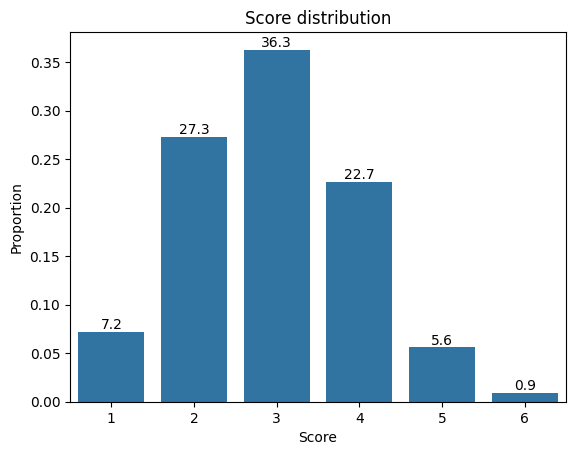

In [4]:
score_count = (
    train_ds["score"]
    .value_counts(normalize=True)
    .rename_axis("score")
    .reset_index(name="proportion")
)
# score_ordered = score_count.score.tolist()
# score_ordered.sort()
ax = sns.barplot(
    x="score",
    y="proportion",
    data=score_count,
    # order=score_ordered
    color=MATPLOTBLUE
)
for p in ax.patches:
    percentage = f"{p.get_height()*100:.1f}"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y, percentage, ha="center", va="bottom")
plt.title("Score distribution")
plt.xlabel("Score")
plt.ylabel("Proportion")
plt.show()
del score_count

The dataset appears to have a distribution that is weighted towards less extreme scores, with a notable decline in the proportion of the highest values. This uneven distribution requires careful consideration during analytical modeling. Special techniques may be necessary to account for the imbalance and to ensure that the analysis is robust, particularly when predicting or interpreting the less represented extreme values.

## What about the text

Addressing the issue of sequence size in the context of natural language processing models such as Sentence-BERT is critical, given the model's token limit restrictions. The typical configuration for such models imposes a cap on the number of tokens that can be processed in a single pass, frequently set at 512 tokens. This constraint poses a significant challenge when attempting to encode longer texts, as it necessitates either the omission of content or the application of sophisticated strategies to manage longer sequences effectively. In scholarly discourse, this topic is particularly relevant as it underscores a limitation within state-of-the-art language models when confronted with lengthy documents. It opens up an area for methodological advancements and innovative techniques aimed at preserving the semantic richness of extensive texts without compromising the quality of the generated embeddings. Focusing on the sequence size involves exploring and refining these techniques, which may include partitioning the text into smaller, manageable units while ensuring minimal loss of contextual information. The implications of such methods are profound, impacting both the efficiency of computational processes and the fidelity of text interpretation, especially in domains where the precision of language is paramount. Let's observe the distribution of the text size.

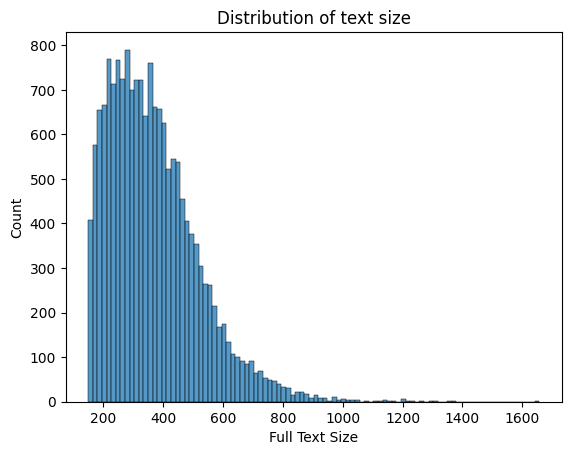

In [5]:
full_text_size = train_ds.full_text.map(lambda x: len(x.split()))
sns.histplot(full_text_size)
plt.xlabel("Full Text Size")
plt.ylabel("Count")
plt.title("Distribution of text size")
plt.show()

The graph highlights a right-skewed distribution of text lengths in a dataset, with most texts falling between 200 to 400 units and a few significantly longer outliers. Multiple peaks suggest the presence of several preferred text lengths. Regarding a potential use of Sentence-BERT for modeling, while adept at producing semantically meaningful sentence embeddings, it may face challenges with these longer texts due to token limits causing memory and computational burdens, potential loss of context when texts are truncated, and inefficiencies in encoding lengthy sequences. This underscores the need for strategic text handling to ensure meaningful semantic encoding by Sentence-BERT, particularly for outlier texts that exceed typical length constraints. To circumvent these limitations, a methodology involving the segmentation of longer texts into individual sentences is proposed, thereby allowing Sentence-BERT to operate within its tokenization parameters while preserving the textual integrity. Such segmentation facilitates detailed semantic analysis of each sentence independently, with the subsequent synthesis of these analyses yielding a comprehensive understanding of the text's overarching semantic structure. Enhancing this segmentation approach, the introduction of overlap between consecutive text chunks is advocated. By ensuring that adjacent segments share a subset of sentences, this strategy aims to safeguard the continuity of information, particularly across segment boundaries. This overlapping ensures the retention of crucial context, which is paramount in the construction of a coherent narrative, particularly for extensive documents where interpretative nuances are intrinsically linked to the broader context.

# Data wrangling

## Turn the score label into ordinal

Ordinal regression, also known as ordinal logistic regression or rank regression, is used when the dependent variable (the outcome you're trying to predict) holds an intrinsic order, but the distances between the levels are not known. The classic examples include a Likert scale for surveys (e.g., "strongly disagree," "disagree," "neutral," "agree," "strongly agree"), grades (A, B, C, D, F), or in your case, essay scores. The key advantage of ordinal regression is its ability to handle dependent variables that are more nuanced than simple binary outcomes but don’t have the numeric spacing needed for linear regression. For instance, while we know that grade A is higher than grade B, we cannot say that it is exactly two points higher as we might with numerical scores. This is where ordinal regression comes in—it allows the modeling of the rank order of the dependent variable without making assumptions about the value of the intervals between levels. In the context of modeling essay scores, ordinal regression can predict the rank order of the essays' quality. It is particularly apt for this kind of task because it can learn from the order inherent in the scores without assuming equal spacing between score levels. This can result in more accurate models for ordered categorical data, as it respects the nature of the ranking involved. When using ordinal regression, we need to transform the target variable to reflect the ordinal nature. In a standard regression problem, the target is typically a single column of values. In ordinal regression, however, the target is often expanded into a matrix that represents the ranking order. This matrix enables the model to understand and predict not just whether one essay is better than another but the relative ranking across the spectrum of scores. To prepare for ordinal regression, your scores can be transformed into an ordinal matrix with a process known as “one-hot encoding” of the ranks. Here’s an example: if the possible scores are 1, 2, 3, 4, and 5, the score of 3 might be represented as [1, 1, 0, 0]. This shows that the essay meets the threshold for scores 1 and 2 but not for scores 4 and 5. This encoding allows the model to learn more nuanced thresholds for each rank level, which can be particularly useful when calculating loss during training and ultimately leads to a model that better understands the ordinal nature of the data.

In [6]:
def category_to_ordinal(category):
    y = np.array(category, dtype="int") 
    n = y.shape[0]
    num_class = np.max(y) 
    range_values = np.tile(
        np.expand_dims(np.arange(num_class), 0), 
        [n, 1]
    ) 
    ordinal = np.zeros((n, num_class), dtype="int") 
    ordinal[range_values < np.expand_dims(y, -1)] = 1 
    return ordinal

In [7]:
train_ds["label"] = category_to_ordinal(train_ds.score.values).tolist()

In [8]:
display(train_ds.head())

,essay_id,full_text,score,label
0,000d118,Many people have car where they live. The thin...,3,"[1, 1, 1, 0, 0, 0]"
1,000fe60,I am a scientist at NASA that is discussing th...,3,"[1, 1, 1, 0, 0, 0]"
2,001ab80,People always wish they had the same technolog...,4,"[1, 1, 1, 1, 0, 0]"
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[1, 1, 1, 1, 0, 0]"
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[1, 1, 1, 0, 0, 0]"


## Create training / validation set

In [9]:
train_set, validation_set = train_test_split(
    train_ds, 
    train_size=.7, 
    random_state=SEED, 
    stratify=train_ds.score
)

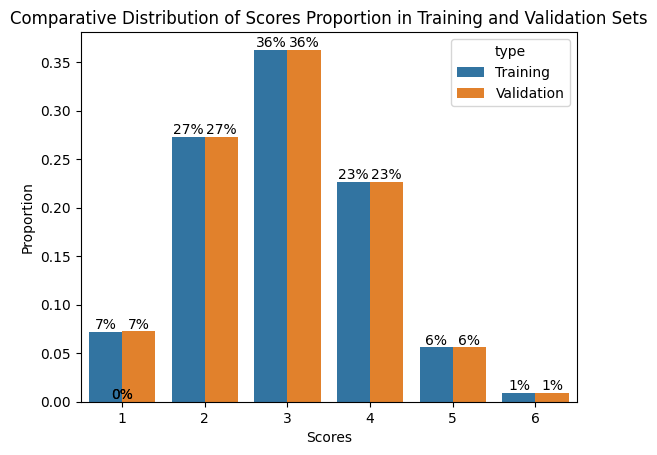

In [14]:
train_set_tmp = train_set.copy()
validation_set_tmp = validation_set.copy()

train_set_tmp["type"] = "Training"
validation_set_tmp["type"] = "Validation"
# ingnore_index force the creation of a new index.
combined_set = pd.concat(
    [train_set_tmp, validation_set_tmp], 
    ignore_index=True
)

proportion = (
    combined_set.groupby("type")["score"]
    .value_counts(normalize=True)
    .reset_index()
)

ax = sns.barplot(proportion, x="score", y="proportion", hue="type")

for p in ax.patches:
    percentage = f"{p.get_height()*100:.0f}%" # type: ignore
    x = p.get_x() + p.get_width() / 2 # type: ignore
    y = p.get_height() # type: ignore
    ax.text(x, y, percentage, ha="center", va="bottom")

plt.title("Comparative Distribution of Scores Proportion in Training and Validation Sets")
plt.xlabel("Scores")
plt.ylabel("Proportion")
plt.show()

del(train_set_tmp)
del(validation_set_tmp)

The provided plot presents a grouped bar chart depicting the distribution of scores within two distinct datasets: Training and Validation. Each score category from 1 to 6 is represented by a pair of bars—one for the Training set (in blue) and one for the Validation set (in orange). The stratification ensures that the proportion of scores in each score category is consistent across both training and validation sets. This consistency is critical when developing a model for ordinal regression, as it allows the model to learn from a training set that mirrors the real-world or expected distribution of scores. Consequently, when the model is validated, the validation set similarly reflects this distribution, allowing for an accurate assessment of the model's performance. From the visual comparison of the bar heights, it is evident that each score's representation in the training set closely matches its representation in the validation set.

In [11]:
type(validation_set)
data_dict = datasets.DatasetDict({
    "training": datasets.Dataset.from_pandas(df=train_set),
    "validation": datasets.Dataset.from_pandas(df=validation_set)
})

# Modeling usin DeBERTa

The development of Bidirectional Encoder Representations from Transformers (BERT, [Delvin et al., 2018](https://arxiv.org/abs/1810.04805)) marked a significant advancement in natural language processing by introducing bidirectional training of Transformer models. This was a departure from previous unidirectional models and utilized strategies such as masked language modeling and next sentence prediction. Subsequent derivatives include Robustly Optimized BERT Pretraining Approach (RoBERTa, [Liu et al., 2019](https://arxiv.org/abs/1907.11692)), which optimized BERT by eliminating the next sentence prediction requirement and adjusting training conditions. DistilBERT ([Sanh et al., 2019](https://arxiv.org/abs/1910.01108)) offered a streamlined version retaining 95% of BERT's performance but with reduced size and enhanced speed through knowledge distillation ([Hinton, Vinyals and Dean, 2015](https://arxiv.org/abs/1503.02531)). Google Research introduced A Lite BERT (ALBERT, [Lan et al., 2019](https://arxiv.org/abs/1909.11942)), which minimized memory usage and complexity, improve parameter efficiency and accelerated training by implementing techniques like factorized embedding parameterization and cross-layer parameter sharing. Lastly, Decoding-enhanced BERT with Disentangled Attention (DeBERTa), developed by Microsoft Research and detailed by He et al. in 2020, enhanced the understanding of context and position in language models. ([He et al., 2020](https://arxiv.org/abs/2006.03654))

Indeed, DeBERTa has evolved through several versions, each introducing significant advancements over its predecessors in the realm of natural language processing. The original version, DeBERTa V1 ([He et al., 2020](https://arxiv.org/abs/2006.03654)), introduced a disentangled attention mechanism that separately processes content and positional information, enabling a more nuanced understanding of word contexts. It also featured an enhanced mask decoder that improved syntax and semantic analysis by predicting both masked tokens and their relative positions. Building on V1, [DeBERTa V2](https://huggingface.co/docs/transformers/v4.40.0/model_doc/deberta-v2) incorporated more advanced training techniques and introduced an XXL model size, which substantially boosted performance across various NLP benchmarks. The latest iteration, DeBERTa V3 ([He et al., 2021](https://arxiv.org/abs/2111.09543)), further refined these capabilities by adopting ELECTRA-style pre-training, which enhances efficiency by training the model to differentiate between correct and incorrect token replacements.

**One way forward**: [BitFit: Simple Parameter-efficient Fine-tuning for Transformer-based Masked Language-models](https://arxiv.org/abs/2106.10199)

The paper "BitFit: Simple Parameter-efficient Fine-tuning for Transformer-based Masked Language-models" presents a novel fine-tuning method for large transformer models, such as BERT and its variants, which optimizes a minimal subset of parameters—specifically the bias terms—while keeping the rest unchanged. This method leverages the finding that updating just the bias parameters can achieve performance comparable to, or sometimes surpassing, that of full model fine-tuning, particularly in situations with limited computational resources or sparse training data. BitFit's approach is highly efficient as it targets only a small fraction of the total model parameters, enhancing its utility in resource-constrained settings. Additionally, its simplicity accelerates training and adaptation, making it ideal for rapid deployment and frequent updates. Importantly, by freezing most of the parameters, BitFit preserves the general knowledge acquired during pre-training, thereby avoiding overfitting on specific fine-tuning datasets and allowing for effective adaptation to new tasks or minor domain shifts without extensive retraining.

In this section, we modelize using DeBERTa as checkpoint. (+ context M&M)

## Tokenize the text

Tokenization is a fundamental process in natural language processing (NLP) where text is segmented into smaller units known as tokens. These tokens may be individual words, characters, or subwords. This segmentation is akin to parsing a sentence into its constituent words or decomposing a word into syllables. 

In [12]:
deberta_v3_tokenizer = AutoTokenizer.from_pretrained(
    configuration_item.model_ckpt
)
deberta_v3_mdl = AutoModelForSequenceClassification.from_pretrained(
    configuration_item.model_ckpt
 )

c:\Users\tddnth\workspace\kaggle\competitions\learning-agency-lab-automated-essay-scoring-2\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\tddnth\workspace\kaggle\competitions\learning-agency-lab-automated-essay-scoring-2\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initia

In [27]:
def encode(batch, tokenizer):
    return tokenizer(
        batch["full_text"], 
        padding=True,
        return_tensors="pt"
    )
data_dict = data_dict.map(
    encode,
    batched=True,
    batch_size=500,
    fn_kwargs={"tokenizer": deberta_v3_tokenizer}
)
data_collator = DataCollatorWithPadding(
    tokenizer=deberta_v3_tokenizer,
    return_tensors="pt"
)

training_dataloader, validation_dataloader = tuple(
    DataLoader(d, batch_size=64, shuffle=True)  # type: ignore
    for d in data_dict.items()
)

Map:   0%|          | 0/12114 [00:00<?, ? examples/s]

Map:   0%|          | 0/5193 [00:00<?, ? examples/s]

## Set the classifier

In this section, I outline the structural framework for our model, incorporating an innovative technique known as Low-Rank Adaptation (LoRA) as proposed by [Yu et al., 2023](https://arxiv.org/abs/2309.15223). LoRA is a method specifically designed to enhance the efficiency of fine-tuning large pre-trained models. This is achieved by reducing the number of trainable parameters, thereby simplifying the model adaptation process and decreasing the computational overhead. The key advantage of using LoRA lies in its ability to retain the performance of the original model while significantly cutting down on the resources required for fine-tuning. This is accomplished by introducing low-rank matrices that modify the existing weights of a pre-trained model rather than retraining all parameters. This selective updating allows us to maintain a balance between computational efficiency and model effectiveness. Implementing LoRA involves decomposing the parameter matrices into smaller, more manageable components, which are easier to optimize. This method not only speeds up the adaptation process but also reduces the memory footprint, making it feasible to fine-tune large models on more modest hardware setups.

In [50]:
mdl = AutoModel.from_pretrained(configuration_item.model_ckpt)
input_ids = data_dict["training"][:1]["input_ids"]
attention_mask = data_dict["training"][:1]["attention_mask"]
if not isinstance(input_ids, torch.Tensor):
    input_ids = torch.tensor(input_ids, dtype=torch.long)
    attention_mask = torch.tensor(attention_mask, dtype=torch.long)
itchi = mdl(input_ids=input_ids, attention_mask=attention_mask)
a=1

In [80]:
from sklearn.base import BaseEstimator, ClassifierMixin

class EncoderForOrdinalRegression(nn.Module):
    """
    A neural network module designed for encoding purposes, 
    based on PyTorch's Module class.

    Attributes:
        * config (dict): Configuration dictionary containing parameters 
            for the encoder network.
    """
    def __init__(self, config):
        """
        Initialize the EncoderNetwork with the specified configuration.

        Parameters:
            config (dict): Configuration parameters for initializing the network. 
                See the class docstring for expected keys and values.
        """
        super().__init__()
        self.pretrained = AutoModel.from_pretrained(config.model_ckpt)
        self.output_layer = nn.Linear(
            self.pretrained.config.hidden_size,
            config.num_labels
        )

    def forward(self, input_ids, attention_mask):
        """
        Define the forward pass of the encoder network.

        Parameters:
            batch (tensor): Input data batch to be processed by the network.

        Returns:
            tensor: The output of the network after processing the input batch, 
                typically involving encoding and subsequent classification or 
                transformation depending on the network configuration.
        """
        outputs = self.pretrained(
            ## deberta forward method that overrides the __call__
            ## https://huggingface.co/docs/transformers/v4.40.2/en/model_doc/deberta-v2#transformers.DebertaV2Model.forward
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = self.output_layer(
            # Only keeping the [CLS] token
            outputs.laset_hidden_state[:, 0, :]
        )
        probs = torch.sigmoid(logits)
        return probs


In [ ]:
# The train function will be included inside the fit function of the Estimator class defined below

def train_model(
    model, 
    train_loader, 
    eval_loader, 
    optimizer, 
    config,
    epochs=3
):
    for epoch in range(epochs):
        model.train() # -> the model is turned into a "trainig" state.
        total_loss = 0
        for batch in train_loader:
            batch = tuple(b.to(config.device) for b in batch)
            inputs, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask
            )
            # Binary Cross Entropy loss (https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
            loss=nn.BCELoss()(outputs, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Mean Loss: {total_loss / len(train_loader)}")
        model.eval() # -> Turn the model into a "evalutation" state.
        with torch.no_grad():
            eval_loss = 0
            for batch in eval_loader:
                batch = tuple(b.to(config.device) for b in batch)
                input_ids, attention_mask, labels = batch
                outputs = model(
                    input_ids = input_ids, 
                    attention_mask = attention_mask
                )
                loss = nn.BCELoss()(outputs, labels.float())
                eval_loss += loss.item()
            print(f"Mean Evaluation Loss: {eval_loss / len(eval_loader)}")

In [ ]:
class EncoderClassifier(BaseEstimator, ClassifierMixin):
    """
    A classifier that encapsulates an encoder network for 
    feature extraction followed by classification.

    Attributes:
        encoder_network (EncoderNetwork): An instance of EncoderNetwork 
            used for encoding input data.
        conf (dict, optional): Configuration dictionary for 
            classifier specific settings.
    """
    def __init__(self, encoder_network, config=None):
        """
        Initialize the EncoderClassifier with an encoder network 
        and an optional configuration.

        Parameters:
            encoder_network (EncoderNetwork): The encoder network 
                to use for data encoding.
            conf (dict, optional): Additional configuration for 
                the classifier. Defaults to None.
        """
        self.encoder_network = encoder_network
        self.config = config if config is not None else {}

    def fit(self, X, y):
        """
        Fit the classifier to the training data. 
        This method should implement learning from the data.

        Parameters:
            X (array-like): Training data features.
            y (array-like): Training data labels or target values.
        """
        pass

    def predict(self, X):
        """
        Predict the labels of the input data using the trained classifier.

        Parameters:
            X (array-like): Data features for which 
                predictions are to be made.

        Returns:
            array: Predicted labels for the input data.
        """
        pass

In [82]:
encoder = EncoderForOrdinalRegression(config=configuration_item)

c:\Users\tddnth\workspace\kaggle\competitions\learning-agency-lab-automated-essay-scoring-2\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
# TODO: set the configuration dataclass.

collate_fn = DataCollatorWithPadding(
    tokenizer=deberta_v3_tokenizer,
    padding="longest",
    return_tensors="pt"
)


In [38]:
deberta_v3_tokenizer.pad()

TypeError: PreTrainedTokenizerBase.pad() missing 1 required positional argument: 'encoded_inputs'

# Modeling using ALBERT